<a href="https://colab.research.google.com/github/namoshi/IG_VAE/blob/main/ae_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Autoencoder for MNIST



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [7]:
# ハイパーパラメータ
batch_size = 128
latent_dim = 128  # 中間層の次元
epochs = 20
learning_rate = 1e-3
beta = 1.0  # KLダイバージェンスの重み

# MNISTデータセットの読み込みとデータローダーの作成
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#print(train_dataset[0])


In [8]:
# Linear AEモデルの定義
class AE(nn.Module):
    def __init__(self, latent_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28*1, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 28*28*1)
        )

    def encode(self, x):
        return self.encoder(x)


    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon


In [9]:
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


AE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
  )
)
Epoch 1, Loss: 14.8851
Epoch 2, Loss: 4.8752
Epoch 3, Loss: 3.9166
Epoch 4, Loss: 3.6444
Epoch 5, Loss: 3.5351
Epoch 6, Loss: 3.5041
Epoch 7, Loss: 3.4882
Epoch 8, Loss: 3.4660
Epoch 9, Loss: 3.4611
Epoch 10, Loss: 3.4659
Epoch 11, Loss: 3.4574
Epoch 12, Loss: 3.4573
Epoch 13, Loss: 3.4585
Epoch 14, Loss: 3.4534
Epoch 15, Loss: 3.4481
Epoch 16, Loss: 3.4522
Epoch 17, Loss: 3.4515
Epoch 18, Loss: 3.4502
Epoch 19, Loss: 3.4469
Epoch 20, Loss: 3.4513


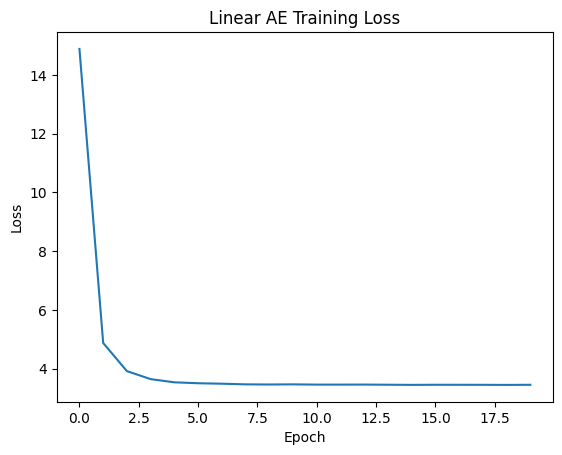

In [10]:
# モデル、損失関数、最適化手法の定義
model = AE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

def loss_function(recon_x, x):
#    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    return MSE

# 学習ループ
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28*1)  # Flatten the input
        data = data.to(torch.float32)  # Ensure the data is in float32 format
        data = data.to(next(model.parameters()).device)  # Move data to the same device as the model
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}')

# 学習曲線のプロット
plt.plot(train_losses)
plt.title('Linear AE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [11]:
# MSE loss の計算
def calculate_mse_loss(model, data_loader):
    model.eval()
    mse_loss = 0.0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.view(-1, 28*28*1)  # Flatten the input
            data = data.to(torch.float32)  # Ensure the data is in float32 format
            data = data.to(next(model.parameters()).device)  # Move data to the same device as the model
            recon_batch = model(data)
            mse_loss += nn.functional.mse_loss(recon_batch, data, reduction='sum')
    return mse_loss / len(data_loader.dataset)
# MSE loss の計算
mse_loss = calculate_mse_loss(model, train_loader)
print(f'MSE Loss: {mse_loss:.4f}')

MSE Loss: 3.4132


z_list shape: (60000, 128)


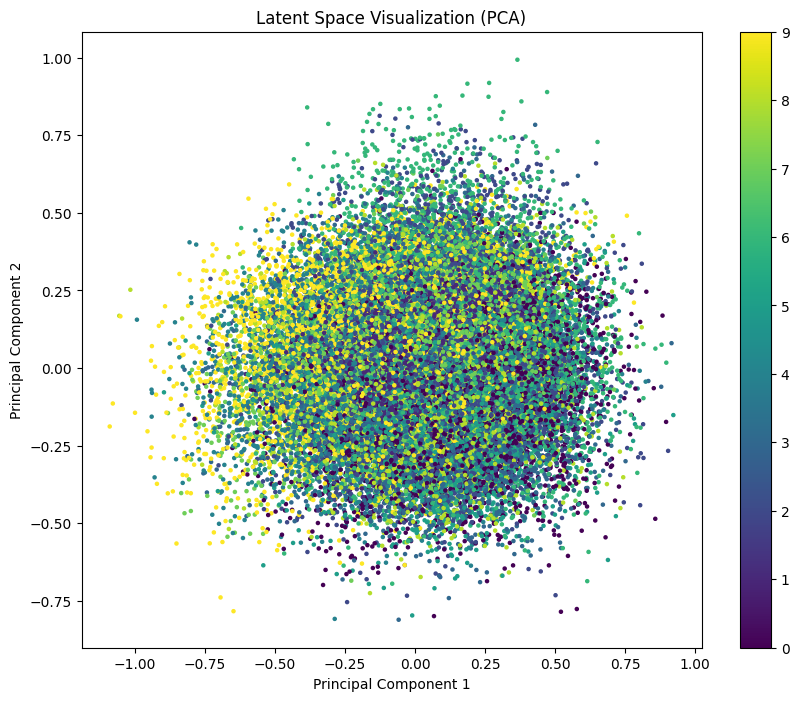

In [12]:
# 中間層の出力の可視化 (PCA適用)
model.eval()
z_list = []
labels_list = []
with torch.no_grad():
    for data, labels in train_loader:
        data = data.view(-1, 28*28*1)  # Flatten the input
        data = data.to(torch.float32)  # Ensure the data is in float32 format
        data = data.to(next(model.parameters()).device)  # Move data to the same device as the model
        z = model.encode(data)
        z_list.extend(z.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
z_list = np.array(z_list)
labels_list = np.array(labels_list)

print(f"z_list shape: {z_list.shape}")

# PCAを使用して次元削減
#pca = PCA(n_components=2)
#z_pca = pca.fit_transform(z_list)

plt.figure(figsize=(10, 8))
plt.scatter(z_list[:, 0], z_list[:, 1], c=labels_list, cmap='viridis', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



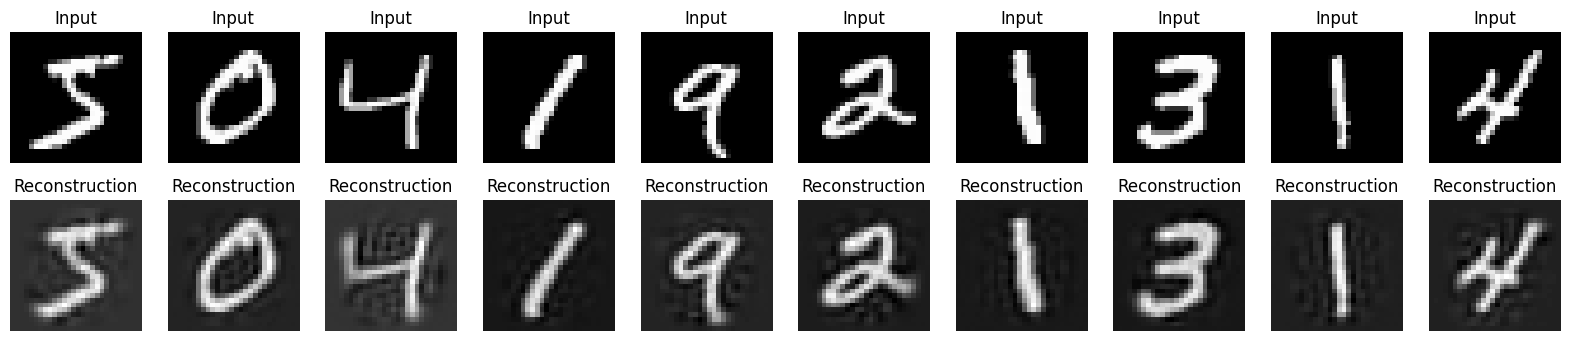

In [13]:
# 入力画像と再構成画像の比較
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    with torch.no_grad():
        sample = train_dataset[i][0].unsqueeze(0)
        sample = sample.view(-1, 28*28*1)  # Flatten the input
        sample = sample.to(torch.float32)  # Ensure the data is in float32 format
        sample = sample.to(next(model.parameters()).device)  # Move data to the same device as the model
        recon_sample = model(sample)
#    print(sample.shape, recon_sample.shape)
    recon_sample = recon_sample.view(-1, 28, 28, 1)  # Reshape for visualization
    recon_sample = recon_sample.cpu()  # Move to CPU for visualization
    sample = sample.view(-1, 28, 28, 1)  # Reshape for visualization
    sample = sample.cpu()  # Move to CPU for visualization
    # 画像の表示
    sample = sample.squeeze()  # Remove batch dimension for visualization
    recon_sample = recon_sample.squeeze()  # Remove batch dimension for visualization
    plt.subplot(2, n, i+1)
    plt.imshow(sample.squeeze().numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_sample.squeeze().numpy(), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
plt.show()